In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wrds
import psycopg2
import statsmodels.api as sm

In [4]:
db = wrds.Connection(wrds_username="grimaux")

Loading library list...
Done


In [5]:
# we download the stocks returns 
stocks_returns_raw = db.raw_sql("""
                      select distinct a.permno, a.date,
                      a.ret, a.prc , a.shrout ,  a.hsiccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1990' and '12/31/2021'
                      and b.exchcd = 1 or b.exchcd = 2
                      and b.shrcd = 10 or b.exchcd = 11
                      """, date_cols=['date']) 

#we download the risk free rate
risk_free=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1990-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])
risk_free = risk_free.rename(
    columns ={"mcaldt" : "date", "tmytm" :"risk_free" })
risk_free = risk_free.set_index("date")
# downlad index returns
market_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1990-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])
market_index = market_index.set_index("date")
#we tranform the returns of the risk free rate
risk_free['risk_free']=np.exp(risk_free['risk_free']/(12*100))-1

In [6]:
stocks_returns_raw["Market Cap"] = np.abs(stocks_returns_raw["prc"] * stocks_returns_raw["shrout"])
stocks_returns_raw["Year"] = pd.DatetimeIndex(stocks_returns_raw['date']).year
stocks_returns_raw

,permno,date,ret,prc,shrout,hsiccd,Market Cap,Year
0,41363.0,1966-11-30,0.021429,17.875000,707.0,5090.0,1.263762e+04,1966
1,58318.0,2005-08-31,0.007435,48.779999,49400.0,3537.0,2.409732e+06,2005
2,90916.0,1995-11-30,0.117647,4.750000,19511.0,6531.0,9.267725e+04,1995
3,81912.0,2007-10-31,-0.037888,15.450000,171904.0,3675.0,2.655917e+06,2007
4,46009.0,1978-07-31,0.029703,13.000000,1131.0,3843.0,1.470300e+04,1978
...,...,...,...,...,...,...,...,...
116949,81598.0,2017-04-28,-0.016955,93.930000,138176.0,5191.0,1.297887e+07,2017
116950,14010.0,2014-02-28,0.001070,37.430000,8700.0,7371.0,3.256410e+05,2014
116951,75313.0,1996-05-31,0.007051,7.375000,38995.0,6726.0,2.875881e+05,1996
116952,88485.0,2016-07-29,0.080357,7.260000,64743.0,4813.0,4.700342e+05,2016


In [7]:
stocks_returns_1995 =stocks_returns_raw[stocks_returns_raw["Year"]==1995]
stocks_returns_1995 = stocks_returns_1995.groupby(by = ["permno"]).mean()

In [11]:
number_observations=stocks_returns_raw.groupby(by=["permno"]).count()
stocks_returns_pemno_384= number_observations[number_observations["ret"]>=384].index.sort_values()

stocks_returns_raw_clean = stocks_returns_raw.loc[stocks_returns_raw["permno"].isin(stocks_returns_pemno_384) ]

stocks_returns_1995 =stocks_returns_raw_clean[stocks_returns_raw_clean["Year"]==1995]
stocks_returns_1995 = stocks_returns_1995.groupby(by = ["permno"]).mean()
test = stocks_returns_1995.sort_values('Market Cap' , ascending = False)
test = test.head(100)
stocks_returns_pemno = list(test.index)

In [2]:
# put all data into a dataframe indexed by their permno and date, and each return is on the right date
risk_free = risk_free.sort_index()
stocks_ret_matrix = pd.DataFrame(index = risk_free.index, data = risk_free)
stocks_ret_matrix = pd.merge(stocks_ret_matrix, market_index, left_index=True, right_index= True, suffixes=("",""))
for permno in stocks_returns_pemno:
    display()
    stocks_ret_matrix = pd.merge(stocks_ret_matrix,
                  stocks_returns_raw[stocks_returns_raw["permno"]==permno]
                                 .set_index("date")["ret"].rename( permno ),
                  left_index = True, right_index = True, suffixes=("",""))
display(stocks_ret_matrix)

stocks_marketcap_matrix = pd.DataFrame(index = risk_free.index)
for permno in stocks_returns_pemno:
    display()
    stocks_marketcap_matrix = pd.merge(stocks_marketcap_matrix , 
                                      stocks_returns_raw[stocks_returns_raw["permno"] == permno]
                                      .set_index("date")["Market Cap"].rename( permno ),
                left_index = True, right_index = True, suffixes=("",""))
    
display(stocks_marketcap_matrix)

NameError: name 'risk_free' is not defined

In [8]:
test = []
for permno in stocks_returns_pemno:
    test.append(stocks_returns_raw[stocks_returns_raw["permno"]==permno]["hsiccd"])
    
classification = []
for i in range(len(test)):
    categorie = 12
    liste_SIC = list(test[i])
    SIC = liste_SIC[0]
    if ((SIC>=100)and(SIC<=999)) or ((SIC>=2000)and(SIC<=2399)) or ((SIC>=2700)and(SIC<=2749)) or ((SIC>=2770)and(SIC<=2799)) or ((SIC>=3100)and(SIC<=3199)) or ((SIC>=3940)and(SIC<=3989)):
        categorie = 1
    elif ((SIC>=2500)and(SIC<=2519)) or ((SIC>=2590)and(SIC<=2599)) or ((SIC>=3630)and(SIC<=3659)) or ((SIC>=3710)and(SIC<=3711)) or (SIC==3714) or (SIC==3716) or ((SIC>=3750)and(SIC<=3751)) or (SIC==3792) or ((SIC>=3900)and(SIC<=3939)) or ((SIC>=3990)and(SIC<=3999)):
        categorie = 2
    elif (2520<=SIC and SIC<=2589) or (2600<=SIC and SIC<= 2699) or (2750<=SIC and SIC<= 2769) or (3000<=SIC and SIC<= 3099) or (3200<=SIC and SIC<=3569) or (3580<=SIC and SIC<=3629) or (3700<=SIC and SIC<=3709 ) or 3712==SIC or 3713==SIC or 3715==SIC or (3717<=SIC and SIC<=3749) or (3752<=SIC and SIC <= 3791) or (3793<=SIC and SIC <= 3799) or (3830<=SIC and SIC<=3839) or (3860<=SIC and SIC<=3899):
        categorie=3
    elif ((SIC>=1200)and(SIC<=1399)) or ((SIC>=2900)and(SIC<=2999)):
        categorie = 4
    elif (1200<=SIC and SIC <= 1399) or (2900<=SIC and SIC<=2999):
        categorie=5
    elif ((SIC>=3570)and(SIC<=3679)) or ((SIC>=3660)and(SIC<=3692)) or ((SIC>=3694)and(SIC<=3699)) or ((SIC>=3810)and(SIC<=3829)) or ((SIC>=7370)and(SIC<=7379)):
        categorie = 6
    elif ((SIC>=4800)and(SIC<=4899)):
        categorie = 7
    elif ((SIC>=4900)and(SIC<=4949)):
        categorie = 8
    elif ((SIC>=5000)and(SIC<=5999)) or ((SIC>=7200)and(SIC<=7299)) or ((SIC>=7600)and(SIC<=7699)):
        categorie = 9
    elif ((SIC>=2830)and(SIC<=2839)) or (SIC==3693) or ((SIC>=3840)and(SIC<=3859)) or ((SIC>=8000)and(SIC<=8099)):
        categorie = 10
    elif ((SIC>=6000)and(SIC<=6999)):
        categorie = 11
    
    classification.append(categorie)

In [9]:
Permno_Classification = pd.DataFrame(data = { "Permno": stocks_returns_pemno , "SIC": classification})
Permno_Classification

,Permno,SIC
0,12060.0,3
1,11850.0,4
2,11308.0,1
3,13901.0,1
4,22752.0,10
...,...,...
95,34817.0,3
96,11674.0,8
97,34032.0,3
98,45356.0,9


In [10]:
industry_portfolio = pd.read_csv(r'C:\Users\Pierre-Benoit\OneDrive\Documents\EPFL\Master\Master 2\Investment\Exercice7\12_Industry_Portfolios.csv',skiprows = 11 , nrows = 1146)
industry_portfolio = industry_portfolio[774:]/100
industry_portfolio["Unnamed: 0"] = risk_free.index[12:]
industry_portfolio = industry_portfolio.rename(columns = {"Unnamed: 0": "date"})
industry_portfolio = industry_portfolio.set_index("date")
industry_portfolio = industry_portfolio.to_period("M")
industry_portfolio

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,
1991-01,0.0515,0.0729,0.0817,-0.0205,0.0260,0.1494,0.0019,-0.0137,0.0935,0.0454,0.0719,0.0814
1991-02,0.1029,0.1023,0.0590,0.0852,0.0580,0.0622,0.0342,0.0484,0.0830,0.0987,0.1079,0.0801
1991-03,0.0478,0.0116,0.0147,0.0132,0.0116,0.0016,0.0233,0.0171,0.0858,0.0542,0.0586,-0.0091
1991-04,-0.0097,-0.0235,-0.0021,0.0246,0.0229,-0.0295,0.0112,-0.0004,0.0197,-0.0114,0.0169,0.0048
1991-05,0.0360,0.1472,0.0731,-0.0141,0.0789,0.0377,-0.0145,0.0015,0.0765,0.0465,0.0462,0.0534
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,-0.0029,0.0173,0.0068,-0.0135,0.0020,0.0468,0.0140,0.0322,0.0239,0.0285,0.0266,0.0230
2021-09,-0.0457,0.0284,-0.0624,0.1063,-0.0469,-0.0627,-0.0565,-0.0477,-0.0420,-0.0594,-0.0159,-0.0350
2021-10,0.0375,0.3063,0.0451,0.1025,0.0594,0.0769,-0.0430,0.0514,0.0496,0.0232,0.0687,0.0732


# Question 1)

In [11]:
stocks_ret_matrix = stocks_ret_matrix.to_period("M")
stocks_marketcap_matrix = stocks_marketcap_matrix.to_period("M")
display(stocks_ret_matrix)

,risk_free,vwretd,12060.0,11850.0,11308.0,13901.0,22752.0,55976.0,12490.0,18163.0,...,61399.0,46674.0,75064.0,23819.0,28484.0,34817.0,11674.0,34032.0,45356.0,49015.0
date,,,,,,,,,,,,,,,,,,,,,
1990-01,0.006390,-0.070114,-0.034884,-0.060000,-0.108414,-0.090090,-0.067742,-0.050139,0.047809,-0.082562,...,-0.071864,-0.092262,-0.067308,-0.017544,-0.030769,-0.153527,-0.024631,-0.010051,-0.126551,-0.089938
1990-02,0.006441,0.014900,-0.000482,0.012766,0.023593,-0.023102,-0.053633,0.032258,0.065501,-0.001953,...,-0.041284,-0.003279,-0.015464,0.071429,0.063492,0.078431,0.025253,0.036458,0.087045,-0.031963
1990-03,0.006688,0.024148,0.040486,-0.018617,0.065957,0.080236,0.023035,0.075455,0.021661,0.060665,...,0.258373,0.002500,0.091642,0.013966,-0.054229,0.197636,0.007685,0.035176,-0.005236,0.047170
1990-04,0.006283,-0.028283,-0.003891,-0.018970,0.020067,0.059937,0.053957,0.050265,0.027091,0.049077,...,0.053384,0.046358,-0.024272,-0.057851,-0.029024,-0.026616,-0.019900,-0.038641,-0.044737,-0.042342
1990-05,0.006132,0.088935,0.083516,0.074033,0.183607,0.002976,0.135836,0.136020,0.112018,0.169912,...,0.369565,0.047468,0.064677,0.160819,0.005435,0.130859,0.081218,0.015228,0.175317,0.042857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.000034,0.027147,0.017471,-0.037867,-0.012625,0.045587,-0.007545,0.042792,0.007236,0.001125,...,0.058124,-0.037268,0.028154,-0.031673,-0.100602,0.130167,0.025742,0.020851,0.047326,0.114086
2021-09,0.000038,-0.042243,-0.021820,0.078870,-0.060735,-0.075851,-0.006947,-0.058879,-0.010047,-0.018189,...,-0.005052,-0.001187,-0.062101,0.082082,0.139782,-0.158770,-0.064858,-0.085145,-0.086230,0.001457
2021-10,0.000042,0.064657,0.017859,0.096056,0.074328,-0.030975,0.172281,0.072033,-0.099546,0.029040,...,0.156561,0.081498,0.107825,0.155874,0.057099,0.133618,0.014681,0.180018,0.077703,0.055564


The annualized mean return of the momentum strategy is:-4.13%
The annualized Standard Deviation return of the momentum strategy is:28.06%
The Sharpe Ratio of the momentum strategy is:-0.23


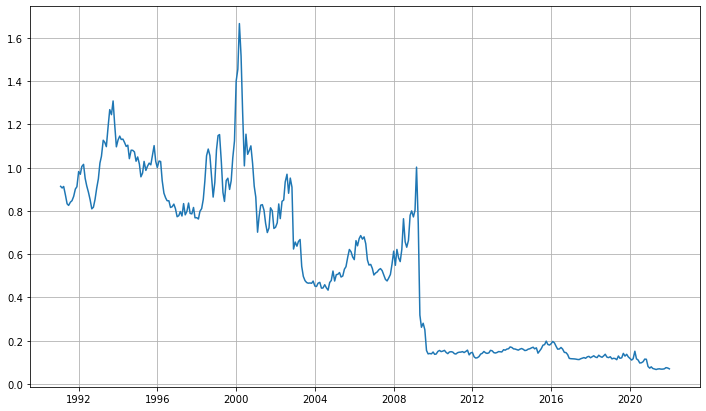

In [12]:

Monthly_Return = [] 
Matrice_Stock_Ret = stocks_ret_matrix.drop(["risk_free","vwretd"] , axis =1)

for current_date in Matrice_Stock_Ret.index[12:]:
    Long_liste = [] #Permno list with stocks that we should long
    Short_liste = [] #Permno list with stocks that we should short
    
    # Select Stocks we want to long and Short
    past_data = (1+Matrice_Stock_Ret[current_date-12: current_date-1]).prod()
    past_data = past_data.sort_values(ascending=True)
    Short_liste = past_data.index[0:10].to_list()
    Long_liste = past_data.index[len(past_data)-10:len(past_data)].to_list()
    
    #Compute the Weights for all 
    weight_Short = [1/10]*10
    weight_Long = [1/10]*10
    
    #Compute the Monthly Return
    gain = weight_Long @ Matrice_Stock_Ret.loc[current_date][Long_liste] - weight_Short @ Matrice_Stock_Ret.loc[current_date][Short_liste]
    Monthly_Return.append(gain)
    
#Creat a DataFrame with Date and Return
Monthly_Ret = pd.DataFrame(index = risk_free.index[12:] ,
                          data = {"Monthly Return": Monthly_Return})

#Creat Cumulative Return DataFrame
Cumulative_Ret = pd.DataFrame(index = risk_free.index[12:] ,
                             data = {"Cumulative Return": (1+Monthly_Ret["Monthly Return"]).cumprod()})

#Compute Mean, Std, Sharpe ratio
Mean_Strategy = Monthly_Ret["Monthly Return"].mean()*12
print(f"The annualized mean return of the momentum strategy is:{Mean_Strategy:.2%}")
Standard_Deviation_Strategy = Monthly_Ret["Monthly Return"].std()*np.sqrt(12)
print(f"The annualized Standard Deviation return of the momentum strategy is:{Standard_Deviation_Strategy:.2%}")
Mean_Risk_Free = stocks_ret_matrix["risk_free"][12:].mean()*12
Sharpe_Ratio_Strategy = (Mean_Strategy - Mean_Risk_Free)/(Standard_Deviation_Strategy)
print(f"The Sharpe Ratio of the momentum strategy is:{Sharpe_Ratio_Strategy :.2}")

#Plot Cumulative Return
plt.figure(figsize=(12,7))
plt.plot(Cumulative_Ret)
plt.grid()

# Question 2)

In [13]:
Monthly_Ret = Monthly_Ret.to_period("M")

In [14]:
#Creat Industry Portfolio Returns: Equally Weighted
X = pd.merge(industry_portfolio , stocks_ret_matrix["vwretd"][12:] , left_index = True , right_index = True)
#We regress the excess premium
model = sm.OLS(Monthly_Ret["Monthly Return"] - stocks_ret_matrix["risk_free"][12:] , sm.add_constant(X) )
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     11.16
Date:                Mon, 02 May 2022   Prob (F-statistic):           3.92e-20
Time:                        14:57:08   Log-Likelihood:                 471.14
No. Observations:                 372   AIC:                            -914.3
Df Residuals:                     358   BIC:                            -859.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.004      0.489      0.6

C:\Users\Pierre-Benoit\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


As we can see on the table above, the market is the most significant driver. It is followd by Money, Energy, Durable goods and Business Equipment where there p-values are lower than 5%. It seems that this regression does not explain very well the strategy performance because the $R^2$ value is low. However, the value of the constante $\alpha$ is also low and seems to be not significant which would suggere that the risk-factors is not so bad for explaining the strategy performance. Hence, we conclude that the model explain well the expected return of this strategy but it does explain not the variance-covariance structure of this strategy.

# Question 3)

In [15]:
#Compute the beta for each stocks
Stocks_Exposure = pd.DataFrame(index = stocks_returns_pemno)
Market_Exposure = []
for permno in stocks_returns_pemno:
    X = stocks_ret_matrix["vwretd"] - stocks_ret_matrix["risk_free"]
    X = X.rename("Market Exposure")
    model = sm.OLS(stocks_ret_matrix[permno] , sm.add_constant(X) )
    results = model.fit()
    Market_Exposure.append(results.params[1])

Stocks_Exposure["Market"] =  Market_Exposure

#Compute the Industry Exposure for each stocks
Exposure_Industry = np.zeros((100,12))

compteur = 0
for SIC in Permno_Classification["SIC"]:
    Exposure_Industry[compteur,SIC-1] = 1
    compteur+=1
    

Stocks_Exposure["NoDur"] =  Exposure_Industry[:,0]
Stocks_Exposure["Durbl"] =  Exposure_Industry[:,1]
Stocks_Exposure["Manuf"] =  Exposure_Industry[:,2]
Stocks_Exposure["Enrgy"] =  Exposure_Industry[:,3]
Stocks_Exposure["Chems"] =  Exposure_Industry[:,4]
Stocks_Exposure["BusEq"] =  Exposure_Industry[:,5]
Stocks_Exposure["Telcm"] =  Exposure_Industry[:,6]
Stocks_Exposure["Utils"] =  Exposure_Industry[:,7]
Stocks_Exposure["Shops"] =  Exposure_Industry[:,8]
Stocks_Exposure["Hlth"] =  Exposure_Industry[:,9]
Stocks_Exposure["Money"] =  Exposure_Industry[:,10]
Stocks_Exposure["Other"] =  Exposure_Industry[:,11]


display(Stocks_Exposure)

C:\Users\Pierre-Benoit\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Market,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
12060.0,1.145665,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11850.0,0.643096,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11308.0,0.578724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13901.0,0.489276,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22752.0,0.567739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34817.0,1.241015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11674.0,0.335629,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34032.0,1.366908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45356.0,1.165587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


C:\Users\Pierre-Benoit\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The Monthly Average Factor Risk Premium are (they are classed in the same order as in the dataframe above):


array([ 2.04730212e-03,  1.68480620e-05,  6.56142800e-04,  1.06754878e-03,
       -9.91766500e-04, -1.77721807e-19, -2.72720381e-04, -1.79745017e-04,
        2.61583329e-04,  2.75116203e-03,  1.53435810e-03,  7.38745413e-04,
        9.55188963e-04])

The Monthly Average Factor Risk t-statistique  are (they are classed in the same order as in the dataframe above):


array([ 0.04294116,  0.02454207, -0.04262171,  0.1086401 , -0.03977836,
        0.04182786,  0.00385493,  0.00032645,  0.0368744 ,  0.19259461,
        0.08517476,  0.06974991,  0.06830488])

The Monthly Average Factor Risk absolute t-statistique  are (they are classed in the same order as in the dataframe above):


array([1.68471675, 1.04489853, 1.1008608 , 1.22738702, 1.92113922,
       1.12135578, 1.18339107, 0.75671175, 1.38300486, 1.2392623 ,
       1.32382223, 1.49108059, 0.96888143])

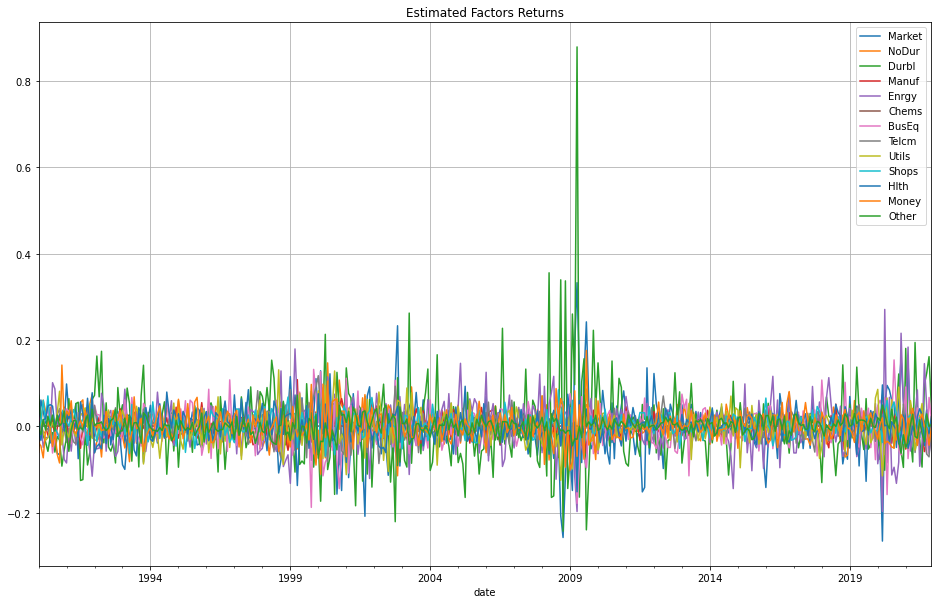

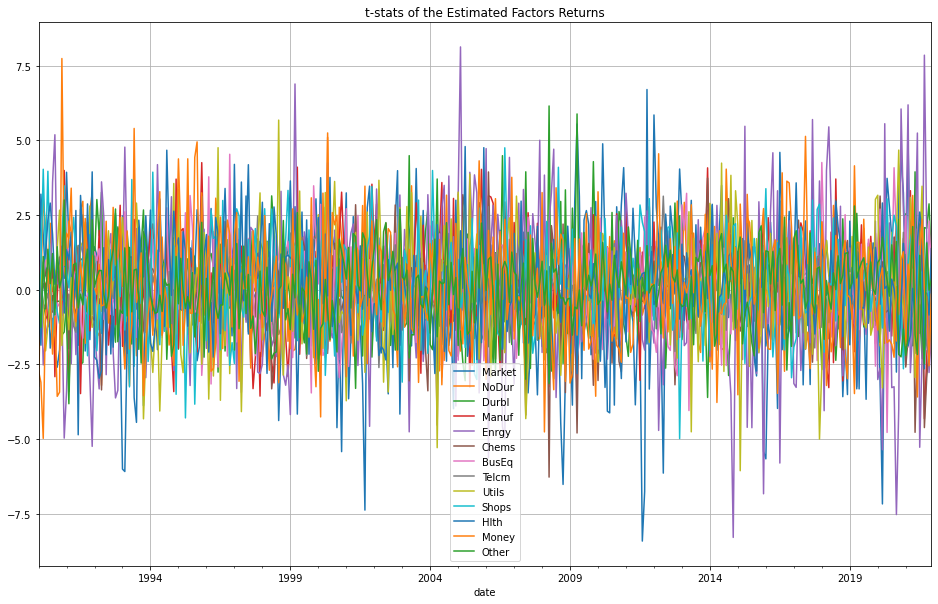

In [16]:
# Computing Monthly factor returns
X = Stocks_Exposure
Factor_Returns_monthly = np.zeros((384,13))
Factor_Returns_monthly_tstat = np.zeros((384,13))
for i in range(384):
    model = sm.OLS(Matrice_Stock_Ret.iloc[i] - stocks_ret_matrix["risk_free"].iloc[i]  , sm.add_constant(X))
    results = model.fit()
    r = np.eye(len(results.params)) 
    for j in range(13):
        Factor_Returns_monthly[i,j] = results.params[j+1]
        Factor_Returns_monthly_tstat[i,j] = results.t_test(r).tvalue[j+1]
      
    

#Creat DataFrame of Factors Returns for each month        
Estimated_Factors_Returns = pd.DataFrame(index = Matrice_Stock_Ret.index,
                                         columns = ["Market" , "NoDur" , "Durbl" , "Manuf" , "Enrgy" , "Chems" , "BusEq" , "Telcm" , "Utils" , "Shops" , "Hlth" , "Money" , "Other"],
                                        data = Factor_Returns_monthly)

#Creat DataFrame of Factors Returns t-statistic for each month
Estimated_Factors_Returns_tstat = pd.DataFrame(index = Matrice_Stock_Ret.index,
                                               columns = ["Market" , "NoDur" , "Durbl" , "Manuf" , "Enrgy" , "Chems" , "BusEq" , "Telcm" , "Utils" , "Shops" , "Hlth" , "Money" , "Other"],
                                              data = Factor_Returns_monthly_tstat)
    
Factors_Return_mean = Factor_Returns_monthly.mean(axis=0)
Factors_Return_tstat_mean = Factor_Returns_monthly_tstat.mean(axis=0)
Factors_Return_tstat_abs_mean = np.abs(Factor_Returns_monthly_tstat).mean(axis=0)

print("The Monthly Average Factor Risk Premium are (they are classed in the same order as in the dataframe above):")
display(Factors_Return_mean)
print("The Monthly Average Factor Risk t-statistique  are (they are classed in the same order as in the dataframe above):")
display(Factors_Return_tstat_mean)
print("The Monthly Average Factor Risk absolute t-statistique  are (they are classed in the same order as in the dataframe above):")
display(Factors_Return_tstat_abs_mean)

#Plot of the Estimated Factors Returns
Estimated_Factors_Returns.plot(figsize = (16,10), title = "Estimated Factors Returns")
plt.grid()

#Plot of the estimated Factors Returns t-statistique
Estimated_Factors_Returns_tstat.plot(figsize = (16,10) , title = "t-stats of the Estimated Factors Returns")
plt.grid()

Only the absolute value of the t-stats are important in order to know if a factor is significant or not.
By looking at the mean of the absolute value of the t-statistics, we conclude that the most important factors are the one with the biggest absolute average. These factors are the following: Energy, Market and Money.

Certain t-statistics vary widely over time from +4 to -4. This can be explained by the fact that certain industries face industrial change that are unexpected (shock). In a case where the industry as a all, faces a growth or a recession, the return is going to be a huge absolute value with a positive sign or a negative sign depend of if it is a growth or a recession. In that case the t-statistic is going to be huge in absolute value because the industry standard deviation is small compare to this change in industry returns.

# Question 4)

In [17]:
Strategy_Exposure = pd.DataFrame(index = Matrice_Stock_Ret.index[12:],
                                columns = ["Market" , "NoDur" , "Durbl" , "Manuf" , "Enrgy" , "Chems" , "BusEq" , "Telcm" , "Utils" , "Shops" , "Hlth" , "Money" , "Other"])

for current_date in Matrice_Stock_Ret.index[12:]:
    Long_liste = [] #Permno list with stocks that we should long
    Short_liste = [] #Permno list with stocks that we should short
    
    # Select Stocks we want to long and Short
    past_data = (1+Matrice_Stock_Ret[current_date-12: current_date-1]).prod()
    past_data = past_data.sort_values()
    Short_liste = past_data.index[0:10].to_list()
    Long_liste = past_data.index[-10:].to_list()
    
    #Select Appropriate beta using Shorted and Longed Stocks
    #We compute the mean because it will give equally weights to each stocks and add their exposure thus obtaining the beta of each portfolio
    Beta_Long = Stocks_Exposure.loc[Long_liste].mean(axis = 0)
    Beta_Short = Stocks_Exposure.loc[Short_liste].mean(axis = 0)
    
    
    Beta_Portfolio = Beta_Long - Beta_Short
    Strategy_Exposure.loc[current_date] = Beta_Portfolio
    
    
Strategy_Impact = Strategy_Exposure * Estimated_Factors_Returns[12:]
display(Strategy_Impact)

#Compute the std for each factors
Strategy_Impact_std = Strategy_Impact.std(axis=0).sort_values()[-3:]
display(Strategy_Impact_std)



  
      

,Market,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
date,,,,,,,,,,,,,
1991-01,-0.060605,0.001493,0.002592,-0.001908,0.008462,0.0,-0.004053,-0.0,-0.0,0.003332,0.008995,-0.021407,-0.002058
1991-02,-0.018957,0.018602,-0.006439,0.009695,0.000302,-0.0,0.0,-0.0,-0.0,0.000287,0.005265,-0.015261,-0.0
1991-03,-0.006738,0.013684,0.003581,0.001836,0.011416,0.0,-0.0,-0.0,0.0,0.00603,0.016001,-0.029734,-0.0
1991-04,-0.000699,-0.004863,-0.000808,0.000813,-0.001096,-0.0,-0.001661,-0.0,-0.0,0.007816,-0.004295,0.00165,0.0
1991-05,-0.025145,0.000452,-0.005306,-0.00832,0.004302,-0.0,-0.000444,-0.0,-0.0,0.006333,0.00385,0.00485,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08,0.032649,-0.002474,-0.00941,-0.000223,-0.003618,0.0,-0.0002,0.0,-0.015973,-0.001649,-0.002631,0.0,0.001568
2021-09,-0.00093,0.000223,0.009647,-0.0,0.029119,-0.0,-0.0,-0.0,-0.0,-0.001727,0.008863,0.000107,0.007116
2021-10,0.033961,0.007928,0.012378,-0.0,0.013561,-0.0,-0.0,-0.0,-0.005102,0.001635,0.000248,-0.001356,-0.008718


Money     0.010228
Enrgy     0.016339
Market    0.034106
dtype: float64

As we can see, the two industries that are most relevant to explain the risk of the strategy are the Energy industry factor and the Money industry factor.
//
In order to obtain these results, we wanted to see the standard deviation contribution of each factors to the strategy return. For that we multiply the exposure ($\beta$) with the factor return coefficient ($F$). We obtained with this operation the impact of each factor on the return. Then, we just needed to compute the standard deviation.

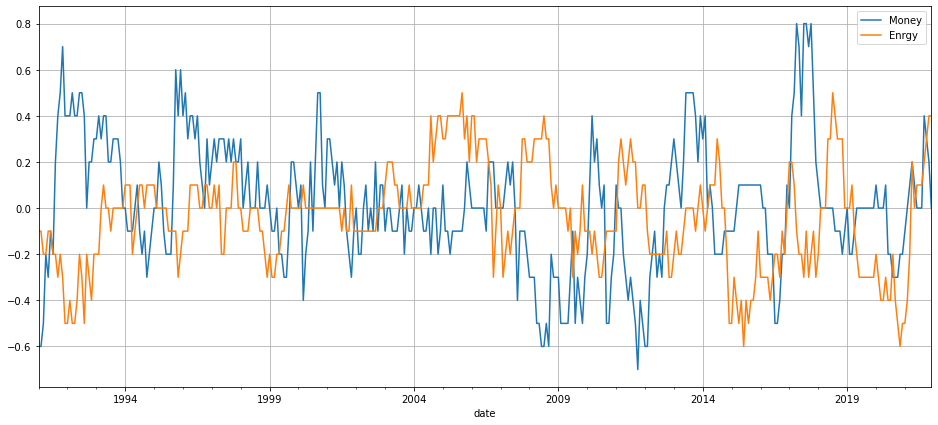

In [18]:
Strategy_Exposure["Money"].plot(figsize = (16,7))
Strategy_Exposure["Enrgy"].plot(figsize = (16,7))
plt.legend()
plt.grid()

In [19]:
Hedge_Strategy = pd.DataFrame(index = Matrice_Stock_Ret.index[12:] , columns = ["Hedge Return"])
Hedge_Strategy["Hedge Return"] = Monthly_Ret["Monthly Return"] - Strategy_Impact.drop(columns = "Market").sum(axis = 1)

display(Hedge_Strategy)
Mean_Strategy = Hedge_Strategy["Hedge Return"].mean()*12
print(f"The annualized mean return of the hedge momentum strategy is:{Mean_Strategy:.2%}")
Standard_Deviation_Strategy = Hedge_Strategy["Hedge Return"].std()*np.sqrt(12)
print(f"The annualized Standard Deviation return of the hedge momentum strategy is:{Standard_Deviation_Strategy:.2%}")
Mean_Risk_Free = stocks_ret_matrix["risk_free"][12:].mean()*12
Sharpe_Ratio_Strategy = (Mean_Strategy - Mean_Risk_Free)/(Standard_Deviation_Strategy)
print(f"The Sharpe Ratio of the hedge momentum strategy is:{Sharpe_Ratio_Strategy :.2}")


,Hedge Return
date,
1991-01,-0.082129
1991-02,-0.020775
1991-03,-0.015020
1991-04,-0.041035
1991-05,-0.052169
...,...
2021-08,0.036825
2021-09,-0.032464
2021-10,0.057977


The annualized mean return of the hedge momentum strategy is:-3.44%
The annualized Standard Deviation return of the hedge momentum strategy is:22.64%
The Sharpe Ratio of the hedge momentum strategy is:-0.25


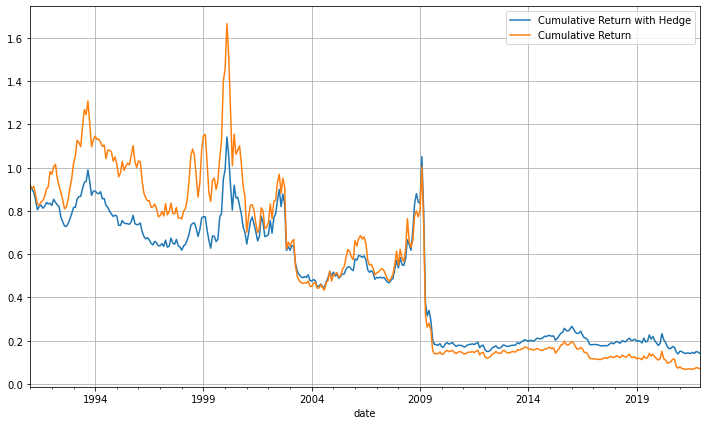

In [20]:
#Creat Cumulative Return DataFrame
Cumulative_Ret_Hedge = pd.DataFrame(index = Matrice_Stock_Ret.index[12:] ,
                             data = {"Cumulative Return with Hedge": (1+Hedge_Strategy["Hedge Return"]).cumprod()})
#Plot Cumulative Return of the hedging strategy
ax = Cumulative_Ret_Hedge.plot(figsize = (12,7))
Cumulative_Ret.plot(ax = ax)
plt.grid()

With Hedging, the agent is taking less risk on change in a particular industry. This can be see around 2000 where the drop of the bubble dot com has been attenuate. However, when all the industries are facing a recession it does not help to hedge again. This second case can be see around 2009 during the subprime crisis where the market as a all dropped.
Finally, we conclude that the momentum strategy is a difficult strategy because the absolute value of the Sharpe Ratio is low. The market could change very quickly and the momentum strategy that we implemented through this exercise use a rolling window of 1 year.